In [54]:
# import drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
!pip install pyspark


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, dayofmonth, month, year
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:

spark = SparkSession.builder.appName("WeatherForecasting").getOrCreate()

# 2. Đọc và tiền xử lý dữ liệu
data = spark.read.option("delimiter", "\t").csv("/content/drive/MyDrive/north_train.txt", header=True, inferSchema=True)
data_test = spark.read.option("delimiter", "\t").csv("/content/drive/MyDrive/north_test.txt", header=True, inferSchema=True)
data.show(7)



+---------+--------------+-----------+--------+--------+----------+--------+
|     city|day/month/year|temperature|humidity|rainfall|wind_speed|uv_index|
+---------+--------------+-----------+--------+--------+----------+--------+
|    Hanoi|    01/01/2024|   22.50 �C|   72.0%|  0.1 mm|  18.7 kph|     6.0|
| Hung Yen|    01/01/2024|   21.90 �C|   72.0%|  0.0 mm|  20.5 kph|     6.0|
|   Ha Nam|    01/01/2024|   22.30 �C|   80.0%|  0.2 mm|  14.8 kph|     6.0|
| Hoa Binh|    01/01/2024|   21.70 �C|   80.0%|  0.3 mm|   8.3 kph|     6.0|
| Bac Ninh|    01/01/2024|   22.20 �C|   69.0%|  0.1 mm|  19.8 kph|     6.0|
|Vinh Phuc|    01/01/2024|   22.50 �C|   72.0%|  0.1 mm|  18.7 kph|     6.0|
|  Phu Tho|    01/01/2024|   28.30 �C|   66.0%|  0.0 mm|  17.3 kph|     7.0|
+---------+--------------+-----------+--------+--------+----------+--------+
only showing top 7 rows



In [58]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col

data_cleaned = data.withColumn(
    "temperature", F.regexp_replace(col("temperature"), "[^0-9.]", "").cast("float")
).withColumn(
    "humidity", F.regexp_replace(col("humidity"), "[^0-9.]", "").cast("float")
).withColumn(
    "rainfall", F.regexp_replace(col("rainfall"), "[^0-9.]", "").cast("float")
).withColumn(
    "wind_speed", F.regexp_replace(col("wind_speed"), "[^0-9.]", "").cast("float")
)
data_test_cleaned = data_test.withColumn(
    "temperature", F.regexp_replace(col("temperature"), "[^0-9.]", "").cast("float")
).withColumn(
    "humidity", F.regexp_replace(col("humidity"), "[^0-9.]", "").cast("float")
).withColumn(
    "rainfall", F.regexp_replace(col("rainfall"), "[^0-9.]", "").cast("float")
).withColumn(
    "wind_speed", F.regexp_replace(col("wind_speed"), "[^0-9.]", "").cast("float")
)

data_cleaned.show(5)


+--------+--------------+-----------+--------+--------+----------+--------+
|    city|day/month/year|temperature|humidity|rainfall|wind_speed|uv_index|
+--------+--------------+-----------+--------+--------+----------+--------+
|   Hanoi|    01/01/2024|       22.5|    72.0|     0.1|      18.7|     6.0|
|Hung Yen|    01/01/2024|       21.9|    72.0|     0.0|      20.5|     6.0|
|  Ha Nam|    01/01/2024|       22.3|    80.0|     0.2|      14.8|     6.0|
|Hoa Binh|    01/01/2024|       21.7|    80.0|     0.3|       8.3|     6.0|
|Bac Ninh|    01/01/2024|       22.2|    69.0|     0.1|      19.8|     6.0|
+--------+--------------+-----------+--------+--------+----------+--------+
only showing top 5 rows



In [59]:

data_cleaned = data_cleaned.withColumn(
    "date", to_date(col("day/month/year"), "dd/MM/yyyy")
)
data_test_cleaned = data_test_cleaned.withColumn(
    "date", to_date(col("day/month/year"), "dd/MM/yyyy")
)
data_model = data_cleaned.select("city", "date", "temperature", "humidity", "rainfall", "wind_speed", "uv_index")
data_test_model = data_test_cleaned.select("city", "date", "temperature", "humidity", "rainfall", "wind_speed", "uv_index")

data_model.show(7)



+---------+----------+-----------+--------+--------+----------+--------+
|     city|      date|temperature|humidity|rainfall|wind_speed|uv_index|
+---------+----------+-----------+--------+--------+----------+--------+
|    Hanoi|2024-01-01|       22.5|    72.0|     0.1|      18.7|     6.0|
| Hung Yen|2024-01-01|       21.9|    72.0|     0.0|      20.5|     6.0|
|   Ha Nam|2024-01-01|       22.3|    80.0|     0.2|      14.8|     6.0|
| Hoa Binh|2024-01-01|       21.7|    80.0|     0.3|       8.3|     6.0|
| Bac Ninh|2024-01-01|       22.2|    69.0|     0.1|      19.8|     6.0|
|Vinh Phuc|2024-01-01|       22.5|    72.0|     0.1|      18.7|     6.0|
|  Phu Tho|2024-01-01|       28.3|    66.0|     0.0|      17.3|     7.0|
+---------+----------+-----------+--------+--------+----------+--------+
only showing top 7 rows



In [60]:
from pyspark.sql.functions import col, sum

# Kiểm tra các giá trị null trong các cột quan trọng
null_counts = data_model.agg(
    sum(col("temperature").isNull().cast("int")).alias("temperature_null"),
    sum(col("humidity").isNull().cast("int")).alias("humidity_null"),
    sum(col("rainfall").isNull().cast("int")).alias("rainfall_null"),
    sum(col("wind_speed").isNull().cast("int")).alias("wind_speed_null"),
    sum(col("uv_index").isNull().cast("int")).alias("uv_index_null")

)

null_counts.show()


+----------------+-------------+-------------+---------------+-------------+
|temperature_null|humidity_null|rainfall_null|wind_speed_null|uv_index_null|
+----------------+-------------+-------------+---------------+-------------+
|               1|            1|            1|              1|            1|
+----------------+-------------+-------------+---------------+-------------+



In [61]:
# Loại bỏ các dòng có giá trị null trong bất kỳ cột nào
data_model = data_model.dropna(subset=["temperature", "humidity", "rainfall", "wind_speed"])

# Kiểm tra lại sau khi loại bỏ dòng có giá trị null
data_model.show()


+---------+----------+-----------+--------+--------+----------+--------+
|     city|      date|temperature|humidity|rainfall|wind_speed|uv_index|
+---------+----------+-----------+--------+--------+----------+--------+
|    Hanoi|2024-01-01|       22.5|    72.0|     0.1|      18.7|     6.0|
| Hung Yen|2024-01-01|       21.9|    72.0|     0.0|      20.5|     6.0|
|   Ha Nam|2024-01-01|       22.3|    80.0|     0.2|      14.8|     6.0|
| Hoa Binh|2024-01-01|       21.7|    80.0|     0.3|       8.3|     6.0|
| Bac Ninh|2024-01-01|       22.2|    69.0|     0.1|      19.8|     6.0|
|Vinh Phuc|2024-01-01|       22.5|    72.0|     0.1|      18.7|     6.0|
|  Phu Tho|2024-01-01|       28.3|    66.0|     0.0|      17.3|     7.0|
|    Hanoi|2024-01-02|       22.7|    77.0|     1.7|      17.6|     6.0|
| Hung Yen|2024-01-02|       22.0|    80.0|     1.1|      17.6|     6.0|
|   Ha Nam|2024-01-02|       21.8|    86.0|     0.6|      13.3|     5.0|
| Hoa Binh|2024-01-02|       22.4|    81.0|     0.9

In [62]:
# convert to pandas
data_model_pd = data_model.toPandas()
data_model_pd.head()

,city,date,temperature,humidity,rainfall,wind_speed,uv_index
0,Hanoi,2024-01-01,22.500000,72.0,0.1,18.700001,6.0
1,Hung Yen,2024-01-01,21.900000,72.0,0.0,20.500000,6.0
2,Ha Nam,2024-01-01,22.299999,80.0,0.2,14.800000,6.0
3,Hoa Binh,2024-01-01,21.700001,80.0,0.3,8.300000,6.0
4,Bac Ninh,2024-01-01,22.200001,69.0,0.1,19.799999,6.0


In [63]:
correlation_matrix = data_model_pd[['temperature', 'humidity', 'rainfall', 'wind_speed', 'uv_index']].corr()
print(correlation_matrix)


             temperature  humidity  rainfall  wind_speed  uv_index
temperature     1.000000 -0.120824  0.100897    0.197588  0.860223
humidity       -0.120824  1.000000  0.391659   -0.265020 -0.432953
rainfall        0.100897  0.391659  1.000000    0.059677 -0.049296
wind_speed      0.197588 -0.265020  0.059677    1.000000  0.279066
uv_index        0.860223 -0.432953 -0.049296    0.279066  1.000000


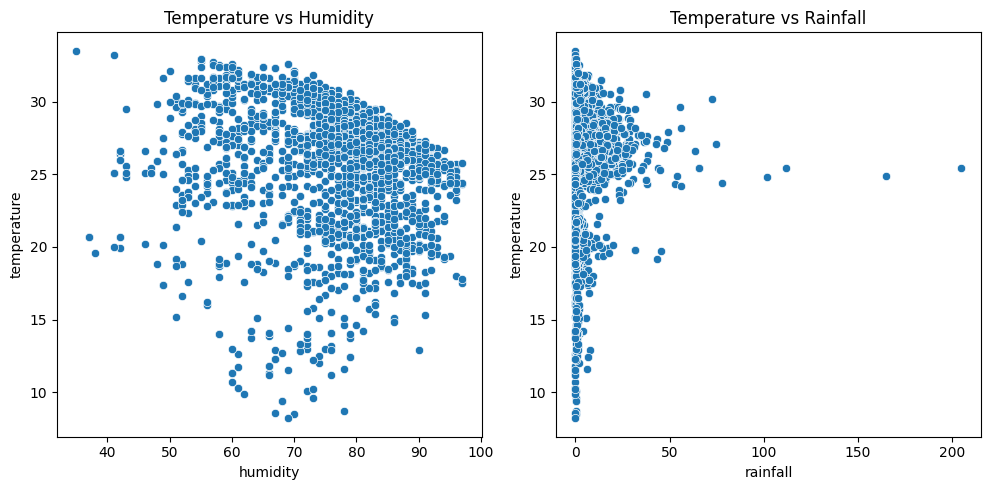

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plots
plt.figure(figsize=(15, 5))

# Temperature vs Humidity
plt.subplot(1, 3, 1)
sns.scatterplot(x='humidity', y='temperature', data=data_model_pd)
plt.title('Temperature vs Humidity')

# Temperature vs Rainfall
plt.subplot(1, 3, 2)
sns.scatterplot(x='rainfall', y='temperature', data=data_model_pd)
plt.title('Temperature vs Rainfall')

plt.tight_layout()
plt.show()


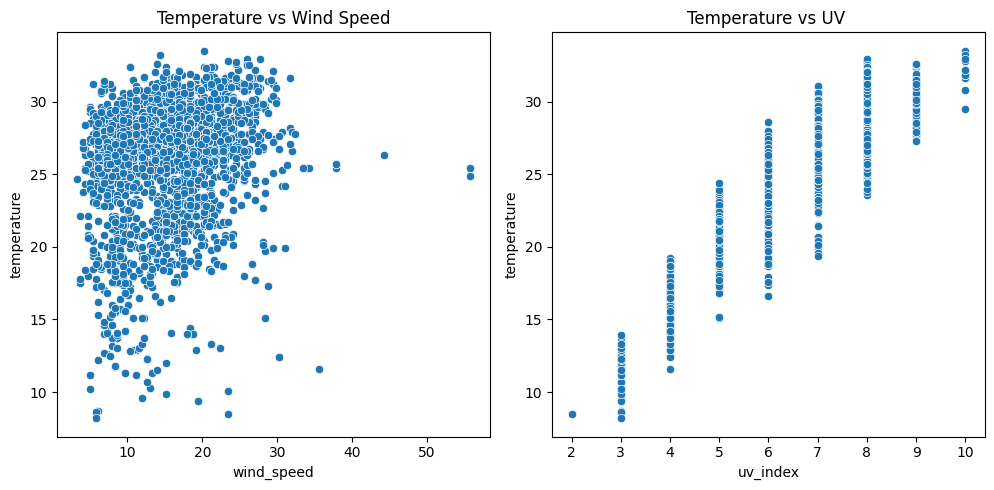

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plots
plt.figure(figsize=(15, 5))
# Temperature vs Wind Speed
plt.subplot(1, 3, 1)
sns.scatterplot(x='wind_speed', y='temperature', data=data_model_pd)
plt.title('Temperature vs Wind Speed')

plt.subplot(1, 3, 2)
sns.scatterplot(x='uv_index', y='temperature', data=data_model_pd)
plt.title('Temperature vs UV ')


plt.tight_layout()
plt.show()

In [65]:
!pip install tensorflow

In [66]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
df_scaled = scaler.fit_transform(data_model_pd[['temperature', 'humidity', 'rainfall', 'wind_speed', 'uv_index']])

# Tạo dữ liệu dạng chuỗi (time series) cho LSTM
# Chọn số bước thời gian (time_steps), ví dụ: 7 ngày
def create_dataset(data, time_steps=7):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, :])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X, y = create_dataset(df_scaled)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
# Biên dịch mô hình

model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Dự đoán và đánh giá mô hình
y_pred = model.predict(X_test)

# Đánh giá mô hình
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.6368 - val_loss: 0.2286
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.3149 - val_loss: 0.3421
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.2751 - val_loss: 0.3281
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.2444 - val_loss: 0.2380
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1917 - val_loss: 0.2299
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1520 - val_loss: 0.1624
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1482 - val_loss: 0.1392
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.1292 - val_loss: 0.1455
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1236 - val_loss: 0.1466
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1197 - val_loss: 0.1939
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1159 - val_loss: 0.1619
Epoch 12/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

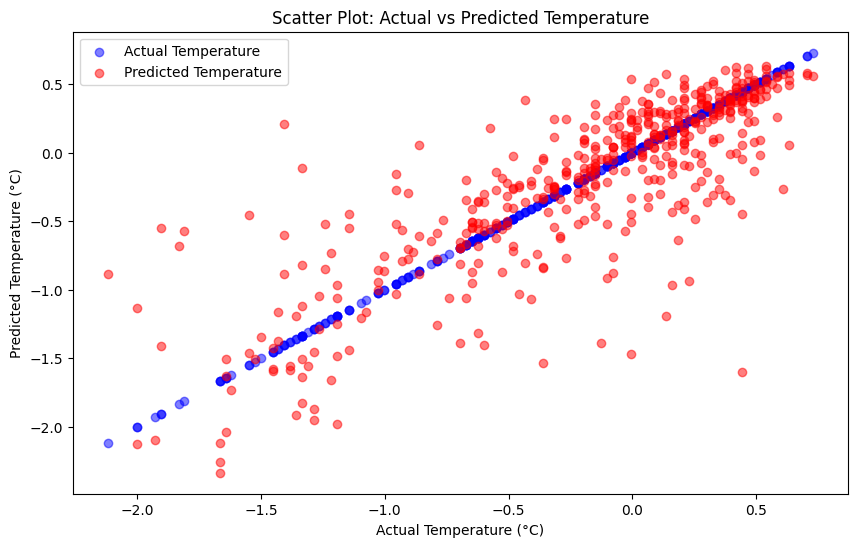

In [67]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ scatter với các điểm khác nhau cho nhiệt độ thực tế và dự đoán
plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_test, color='blue', marker='o', label='Actual Temperature', alpha=0.5)

plt.scatter(y_test, y_pred, color='red', marker='o', label='Predicted Temperature', alpha=0.5)

plt.title('Scatter Plot: Actual vs Predicted Temperature')
plt.xlabel('Actual Temperature (°C)')
plt.ylabel('Predicted Temperature (°C)')
plt.legend()
plt.show()


In [73]:
data_test_pd = data_test_model.toPandas()

In [77]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_test_pd[['temperature', 'humidity', 'rainfall', 'wind_speed', 'uv_index']])

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return np.array(sequences)

seq_length = 6
sequences = create_sequences(scaled_data, seq_length)


X_test = sequences[:, :-1]
y_test = sequences[:, -1, 0]

predicted_temps = []
for i in range(len(X_test)):
    # Dự đoán cho ngày tiếp theo của từng tỉnh thành
    predicted_temp = model.predict(X_test[i].reshape(1, seq_length-1, X_test.shape[2]))
    # Chuyển giá trị dự đoán về đơn vị ban đầu
    predicted_temp = scaler.inverse_transform(np.array([[predicted_temp[0, 0], 0, 0, 0, 0]]))[:, 0]
    predicted_temps.append(predicted_temp[0])

data_test_pd = data_test_pd.iloc[seq_length-1:].reset_index(drop=True)

# Gắn kết giá trị dự đoán vào DataFrame
data_test_pd['predicted_temperature'] = predicted_temps



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━

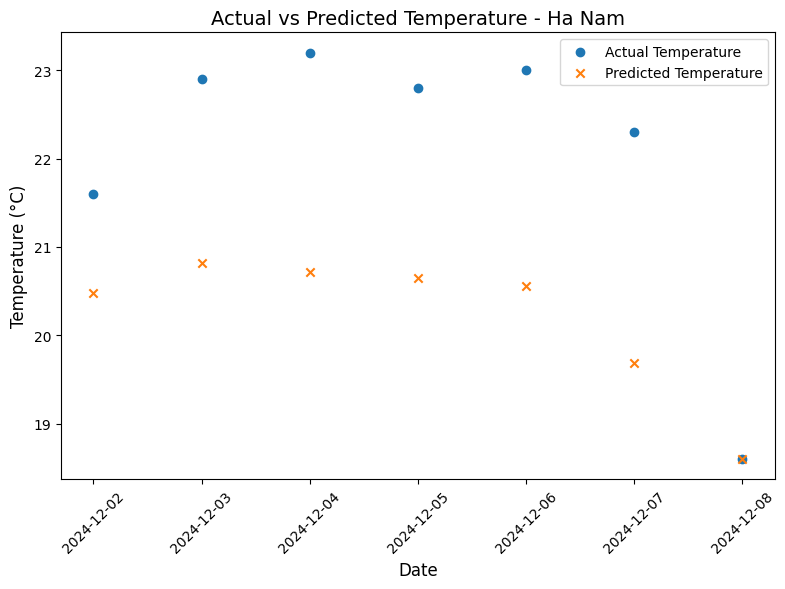

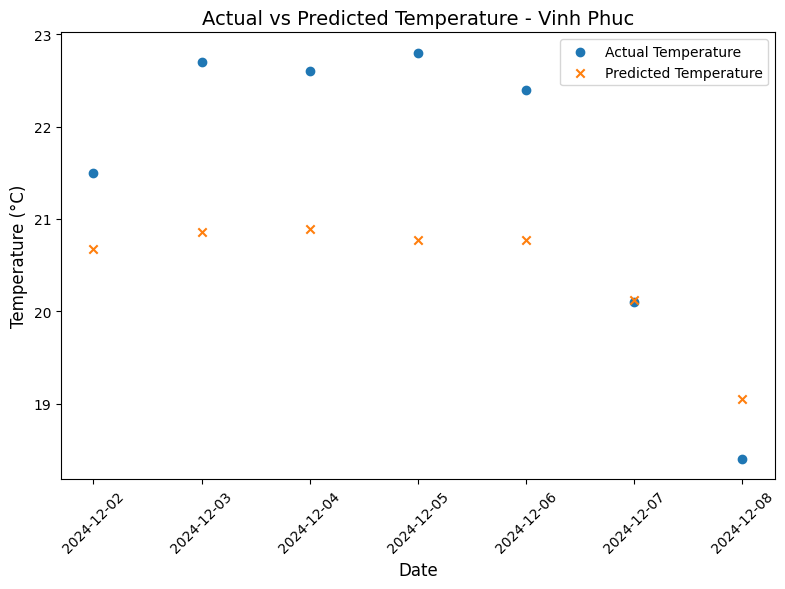

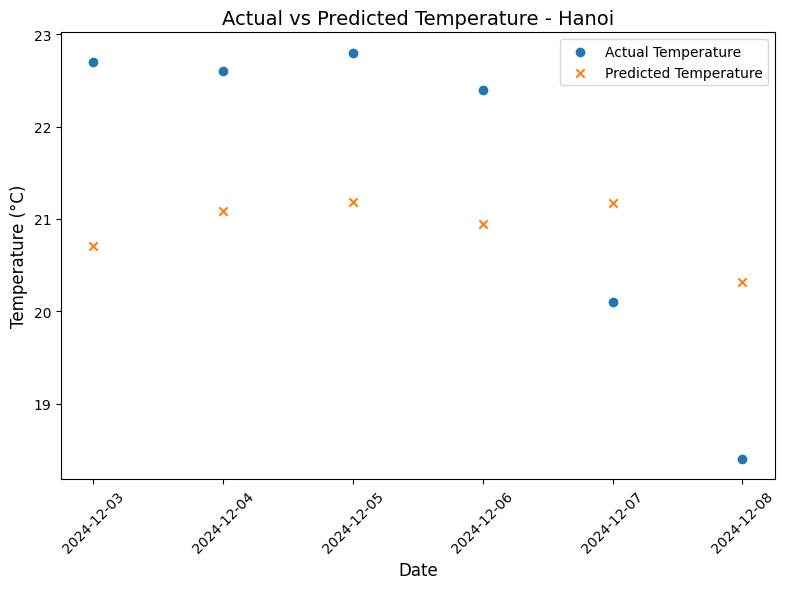

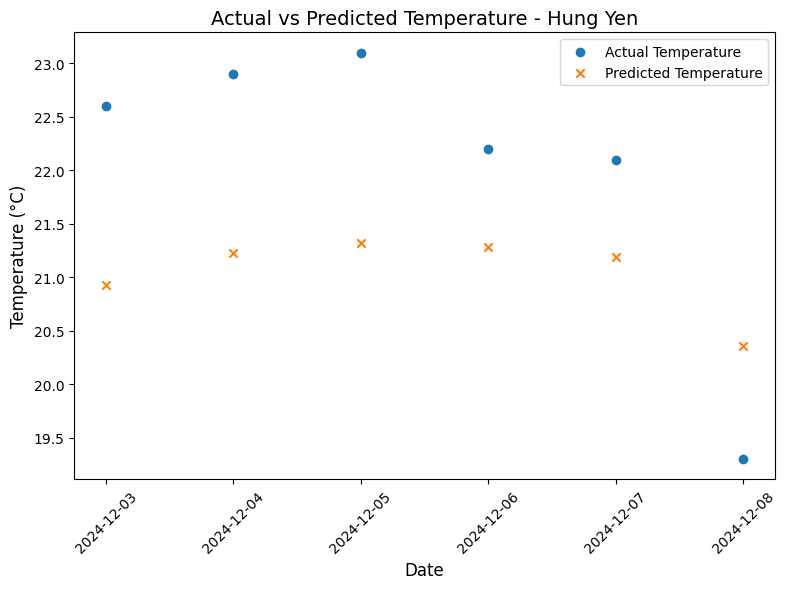

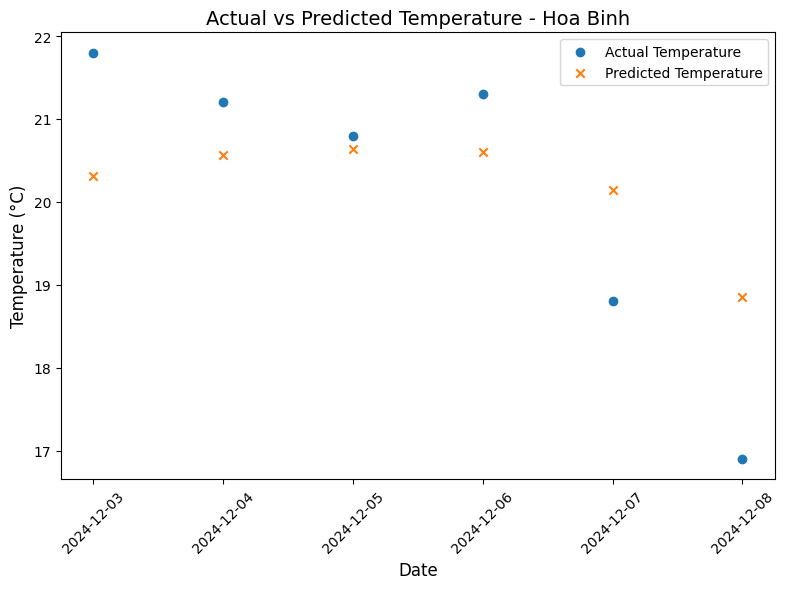

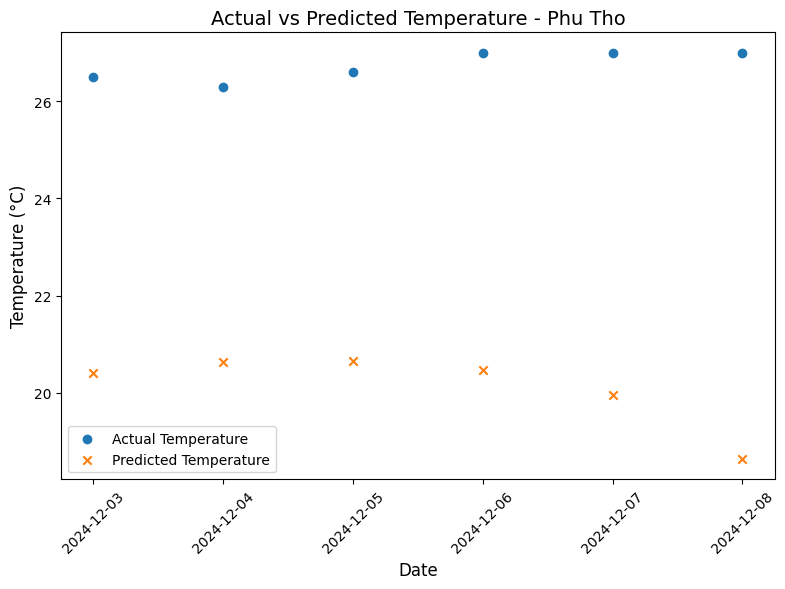

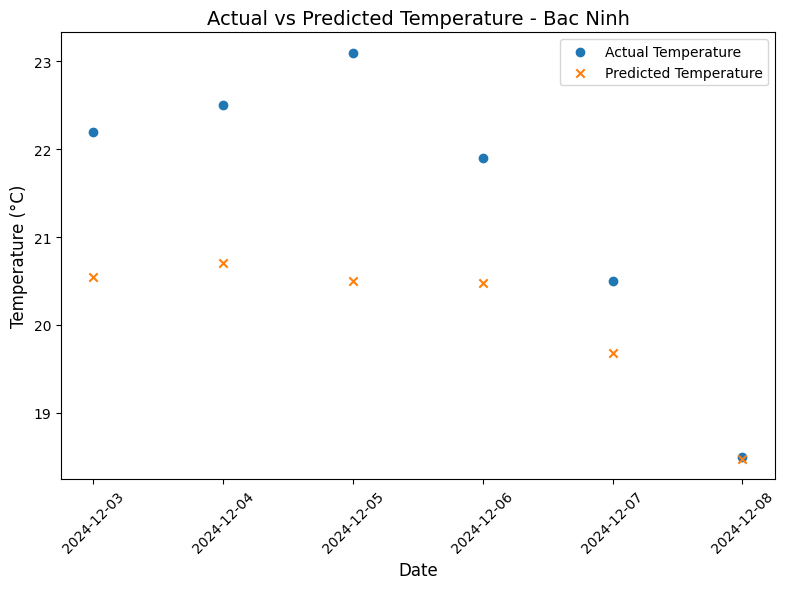

In [80]:
import matplotlib.pyplot as plt

# Duyệt qua từng thành phố trong dữ liệu
for city in data_test_pd['city'].unique():
    city_data = data_test_pd[data_test_pd['city'] == city]

    plt.figure(figsize=(8, 6))

    plt.scatter(city_data['date'], city_data['temperature'], label='Actual Temperature', marker='o')

    plt.scatter(city_data['date'], city_data['predicted_temperature'], label='Predicted Temperature', marker='x')

    # Thêm tiêu đề và nhãn cho các trục
    plt.title(f'Actual vs Predicted Temperature - {city}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)

    plt.xticks(rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()
